In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from wordcloud import WordCloud

nltk.download('stopwords')
from nltk.corpus import stopwords

# Load data
df = pd.read_csv("/kaggle/input/consumer-reviews-of-amazon-products/1429_1.csv", low_memory=False)
df.shape


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(34660, 21)

In [2]:
df = df[['reviews.text', 'reviews.rating', 'reviews.numHelpful', 'reviews.username']].dropna()
df = df[df['reviews.text'].str.strip() != '']
df['text_length'] = df['reviews.text'].apply(lambda x: len(x.split()))

# Label creation: 1 = Fake, 0 = Genuine
def label_fake(row):
    if row['reviews.rating'] == 5.0 and row['reviews.numHelpful'] == 0 and row['text_length'] < 10:
        return 1  # Fake
    else:
        return 0  # Genuine

df['label'] = df.apply(label_fake, axis=1)
df['label'].value_counts()


label
0    33111
1     1013
Name: count, dtype: int64

In [3]:
import string
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# Clean the text
def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['clean_text'] = df['reviews.text'].apply(clean_text)

# TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['clean_text'])

# Labels
y = df['label']


              precision    recall  f1-score   support

     Genuine       0.97      1.00      0.99      6622
        Fake       0.67      0.02      0.04       203

    accuracy                           0.97      6825
   macro avg       0.82      0.51      0.51      6825
weighted avg       0.96      0.97      0.96      6825



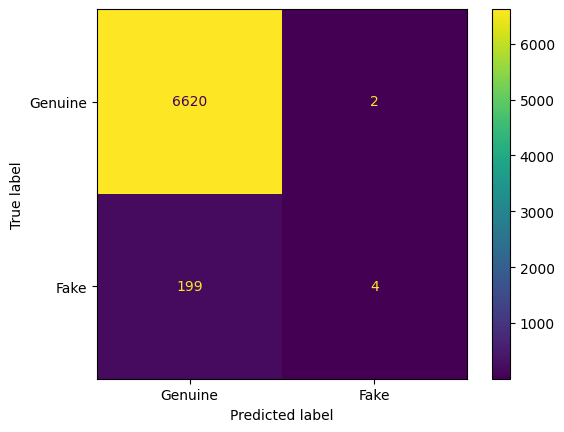

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred, target_names=["Genuine", "Fake"]))

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=["Genuine", "Fake"])


In [5]:
import joblib

# Save model and vectorizer
joblib.dump(model, 'fake_review_detector_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

print("✅ Model and Vectorizer saved successfully.")


✅ Model and Vectorizer saved successfully.


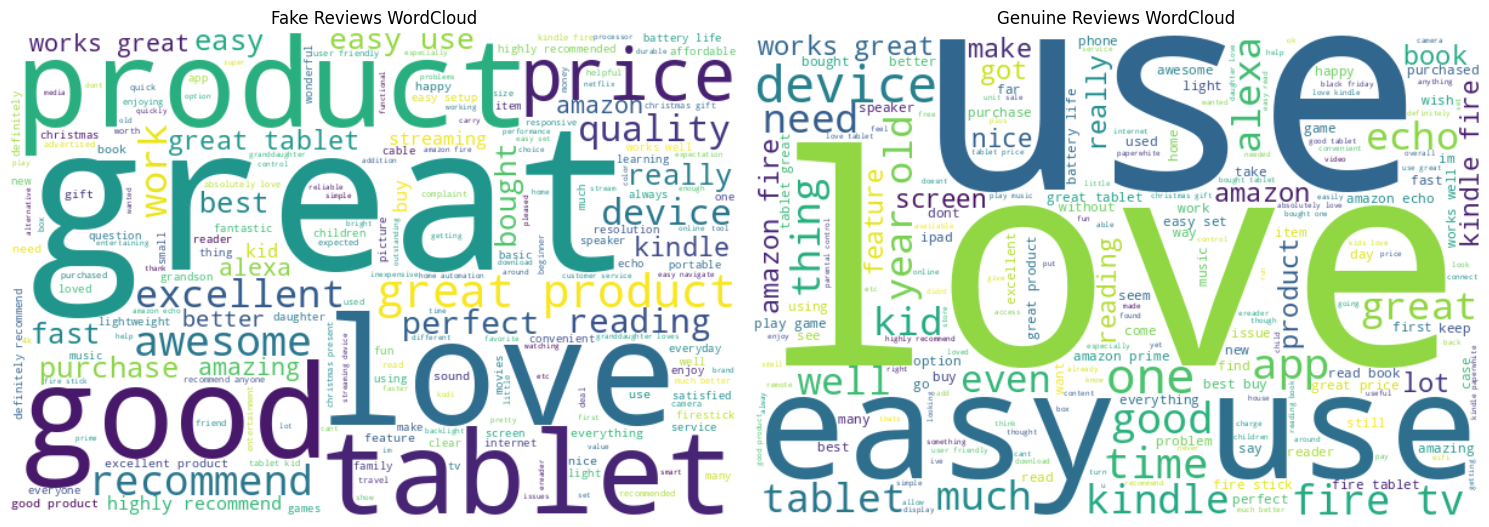

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Separate fake and genuine
fake_reviews = df[df['label'] == 1]['clean_text']
genuine_reviews = df[df['label'] == 0]['clean_text']

# Plot WordClouds
plt.figure(figsize=(15, 7))

# Fake
plt.subplot(1, 2, 1)
wc_fake = WordCloud(width=600, height=400, background_color='white').generate(' '.join(fake_reviews))
plt.imshow(wc_fake, interpolation='bilinear')
plt.axis('off')
plt.title('Fake Reviews WordCloud')

# Genuine
plt.subplot(1, 2, 2)
wc_genuine = WordCloud(width=600, height=400, background_color='white').generate(' '.join(genuine_reviews))
plt.imshow(wc_genuine, interpolation='bilinear')
plt.axis('off')
plt.title('Genuine Reviews WordCloud')

plt.tight_layout()
plt.show()


In [9]:
def predict_review(text):
    # Preprocess the text
    cleaned = clean_text(text)
    vec = vectorizer.transform([cleaned])
    pred = model.predict(vec)[0]
    prob = model.predict_proba(vec)[0][pred]
    label = "Fake" if pred == 1 else "Genuine"
    return f"🧾 Prediction: {label} (Confidence: {prob:.2f})"

# Real-Time Review Prediction Function
print(predict_review("This product is amazing! I love it!"))
print(predict_review("Excellent! Must buy."))
print(predict_review("Worst product ever, doesn't work at all."))


🧾 Prediction: Genuine (Confidence: 0.70)
🧾 Prediction: Genuine (Confidence: 0.84)
🧾 Prediction: Genuine (Confidence: 0.94)


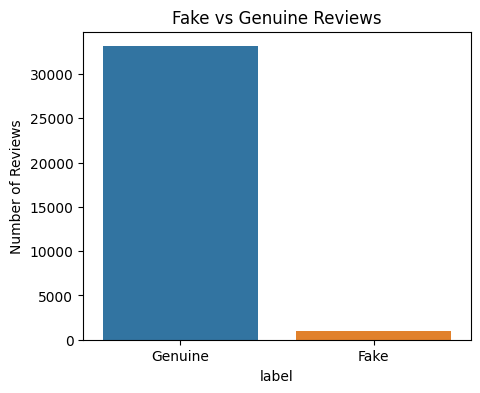

In [10]:
plt.figure(figsize=(5,4))
sns.countplot(x='label', data=df)
plt.title('Fake vs Genuine Reviews')
plt.xticks([0,1], ['Genuine', 'Fake'])
plt.ylabel('Number of Reviews')
plt.show()


/tmp/ipykernel_31/1682109203.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='label', y='reviews.rating', ci=None, palette=['green', 'red'])


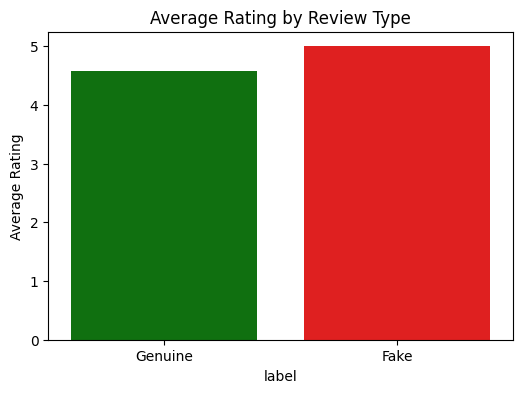

In [12]:
plt.figure(figsize=(6,4))
sns.barplot(data=df, x='label', y='reviews.rating', ci=None, palette=['green', 'red'])
plt.xticks([0,1], ['Genuine', 'Fake'])
plt.title('Average Rating by Review Type')
plt.ylabel('Average Rating')
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


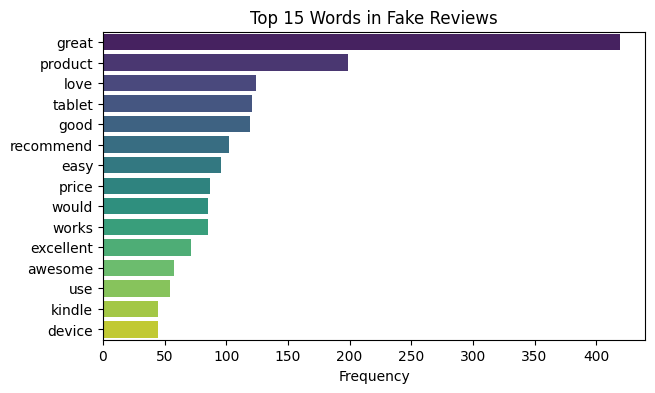

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


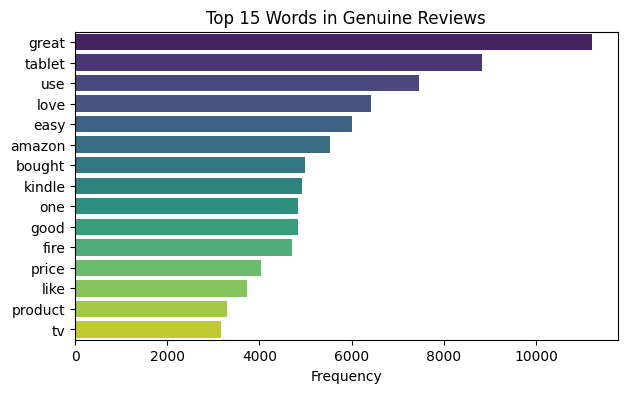

In [13]:
from collections import Counter

def plot_top_words(texts, label, n=15):
    words = ' '.join(texts).split()
    common_words = Counter(words).most_common(n)
    words, counts = zip(*common_words)
    plt.figure(figsize=(7, 4))
    sns.barplot(x=list(counts), y=list(words), palette='viridis')
    plt.title(f"Top {n} Words in {label} Reviews")
    plt.xlabel("Frequency")
    plt.show()

plot_top_words(fake_reviews, "Fake")
plot_top_words(genuine_reviews, "Genuine")
